# **Detección de anomalías con Autoencoder**

Ahora construiremos un autoencoder con la base de datos de MNIST, concretamente con los ceros, que consideraremos como clase normal. En test pasaremos otro conjunto de ceros junto con diez unos y chequearemos si el autoencoder detecta estos como anomalías.

Importaremos las librerías que usaremos y cargamos los datos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator

In [2]:
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(X_tr.shape, X_te.shape)

(60000, 28, 28) (10000, 28, 28)


Ahora dejaremos en training solo los ceros (clase “normal”), y en test solo los ceros también menos 10 unos que dejamos como anomalías:

In [4]:
X_tr2 = X_tr[(y_tr == 0)] # clase 0 es la clase ok
X_te2 = np.vstack((X_te[(y_te == 0)],
                   X_te[(y_te == 1)][:10]))
y_te2 = np.array(sum(y_te==0)*[0] + 10*[1])

In [5]:
print(len(X_tr2), len(X_te2))

5923 990


Ahora reservamos el 30% de training para validación:

In [6]:
X_tr2, X_val2 = train_test_split(X_tr2, test_size=0.3,
                                 random_state=1)

Y normalizamos los datos:

In [7]:
X_tr2 = X_tr2 / 255
X_val2 = X_val2 / 255
X_te2 = X_te2 / 255

A continuación, definimos el autoencoder.
Lo implementaremos con capas densas, por lo que lo primero que realizaremos en la red es aplanar con el operador flatten la imagen de entrada.
Luego reducimos la entrada a 50 componentes con una capa densa de 50 neuronas, a continuación, a 10, y posteriormente realizamos la operación inversa: aumentar de nuevo a 50 componentes y finalmente a 28x28, que se redimensionarán a una salida de 28x28.
La función de activación en la capa de salida es una sigmoide, lo que asegura que las intensidades predichas para los píxeles están en el intervalo (0,1), como corresponde con los valores reales normalizados:

In [8]:
model = keras.Sequential(
    [
     keras.Input((28,28)),
     keras.layers.Flatten(),
     keras.layers.Dense(50, activation="relu"),
     keras.layers.Dense(10, activation="relu"),
     keras.layers.Dense(50, activation="relu"),
     keras.layers.Dense(28*28, activation="sigmoid"),
     keras.layers.Reshape((28,28))
    ]
)

Ahora compilamos la red y extraemos su summary:

In [9]:
model.compile(optimizer='rmsprop', loss="mse")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 50)                550       
                                                                 
 dense_3 (Dense)             (None, 784)               39984     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 80,294
Trainable params: 80,294
Non-traina

Definimos los callbacks:

In [11]:
lista_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        monitor="val_loss",
        save_best_only=True,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    )
]

Y hacemos el entrenamiento de la red:

In [12]:
historia = model.fit(X_tr2, X_tr2, batch_size=128,
                     epochs=200, callbacks=lista_callbacks,
                     validation_data=(X_val2, X_val2))

Epoch 1/200
33/33 [==============================] - 4s 49ms/step - loss: 0.1864 - val_loss: 0.0858
Epoch 2/200
33/33 [==============================] - 1s 24ms/step - loss: 0.0689 - val_loss: 0.0645
Epoch 3/200
33/33 [==============================] - 1s 32ms/step - loss: 0.0637 - val_loss: 0.0635
Epoch 4/200
33/33 [==============================] - 1s 41ms/step - loss: 0.0627 - val_loss: 0.0625
Epoch 5/200
33/33 [==============================] - 1s 28ms/step - loss: 0.0609 - val_loss: 0.0599
Epoch 6/200
33/33 [==============================] - 1s 46ms/step - loss: 0.0572 - val_loss: 0.0553
Epoch 7/200
33/33 [==============================] - 1s 33ms/step - loss: 0.0534 - val_loss: 0.0524
Epoch 8/200
33/33 [==============================] - 1s 35ms/step - loss: 0.0514 - val_loss: 0.0508
Epoch 9/200
33/33 [==============================] - 1s 36ms/step - loss: 0.0499 - val_loss: 0.0492
Epoch 10/200
33/33 [==============================] - 1s 45ms/step - loss: 0.0479 - val_loss: 0.0469

Representamos la evolución del entrenamiento:

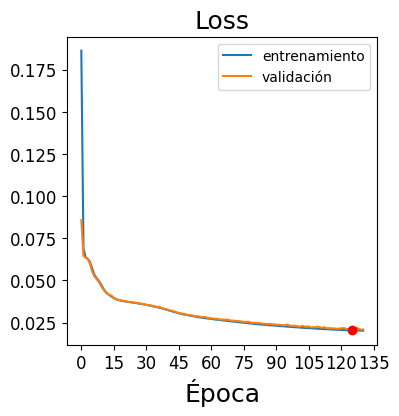

In [13]:
f = plt.figure(figsize=(4,4))
h = historia.history
mejor_epoca = np.argmin(h["val_loss"])
plt.plot(h["loss"], label="entrenamiento")
plt.plot(h["val_loss"], label="validación")
plt.plot(mejor_epoca, h["val_loss"][mejor_epoca], 'or')
plt.title('Loss', fontsize=18)
plt.xlabel('Época', fontsize=18)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend()
f.gca().xaxis.set_major_locator(MaxNLocator(integer=True));

Recuperamos la mejor red en validación:

In [14]:
model = keras.models.load_model("best_model.keras")

Ahora calculamos los errores de reconstrucción en test:

In [15]:
errores = (X_te2 - model.predict(X_te2))**2
print(errores.shape)

31/31 [==============================] - 0s 2ms/step
(990, 28, 28)


In [16]:
error_por_imagen = (errores.sum(axis=1).sum(axis=1)/(28*28))
print(error_por_imagen.shape)

(990,)


Finalmente, mostraremos las 20 imágenes de test con mayor error de reconstrucción (las 20 imágenes de test más anómalas):

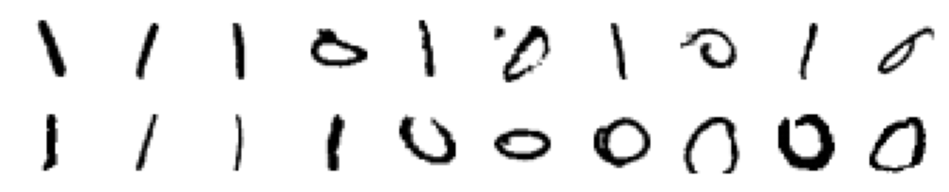

In [17]:
inds = np.argsort(error_por_imagen)[::-1] # saco los índices de los errores de mayor a menor magnitud
plt.figure(figsize=(12,12)) 
cont = 1 
for ind in inds[:20]: 
  plt.subplot(10,10,cont) 
  plt.imshow(X_te2[ind], cmap="binary") 
  plt.axis("off") 
  cont = cont + 1

Como podemos ver, dentro de las 20 imágenes de test más anómalas están los diez unos junto con ceros con características anómalas.